In [3]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import librosa

from scipy.fft import rfft, rfftfreq, fft
from scipy.signal import butter, filtfilt, find_peaks, lfilter
from scipy.ndimage import median_filter

In [4]:
# Parameters for recording
CHUNK = 1024            # Number of audio samples per buffer
FORMAT = pyaudio.paInt16  # each sample is 16 bit
CHANNELS = 1            # Mono audio
RATE = 44100            # Sampling rate in Hz -> how many samples per second
RECORD_SECONDS = 5      # Duration of recording in seconds
AUDIO_FILE = './utils/assets/test_SIV.mp3'
NUMBER_OF_CHUNKS = int(RATE / CHUNK * RECORD_SECONDS)

In [5]:


def from_raw_to_array_of_chunks(raw_audio_data):
    return [raw_audio_data[i:i + CHUNK] for i in range(0, len(raw_audio_data), CHUNK)]
   
def from_array_of_chunks_to_array_of_int(array_of_chunks):
    return np.frombuffer(b''.join(array_of_chunks), dtype=np.int16)

def from_mp3(file_path):

    audio_file_path = file_path  # Replace with your MP3 file path
    audio = AudioSegment.from_mp3(audio_file_path)
    
    # Convert the audio to raw PCM data (in this case, 16-bit mono)
    audio = audio.set_channels(1)  # Ensure mono
    audio = audio.set_frame_rate(RATE)  # Match the desired sample rate
    
    # Convert audio to raw bytes
    raw_audio_data = audio.raw_data
    
    # Process the audio data in chunks as you would with live input
    frames = from_raw_to_array_of_chunks(raw_audio_data)
    
    return from_array_of_chunks_to_array_of_int(frames)
    
    

In [6]:
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [7]:
def plot_signal(audio_signal):
   
    time_axis = np.linspace(0, len(audio_signal) / RATE, num=len(audio_signal))
    # Plot the time-domain signal
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, audio_array)
    plt.title('Time Domain Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

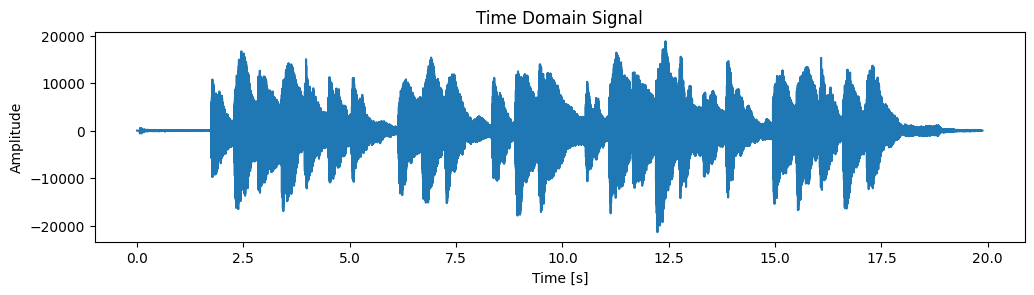

In [8]:
audio_array = from_mp3(AUDIO_FILE)
n_samples = len(audio_array)
plot_signal(audio_array)

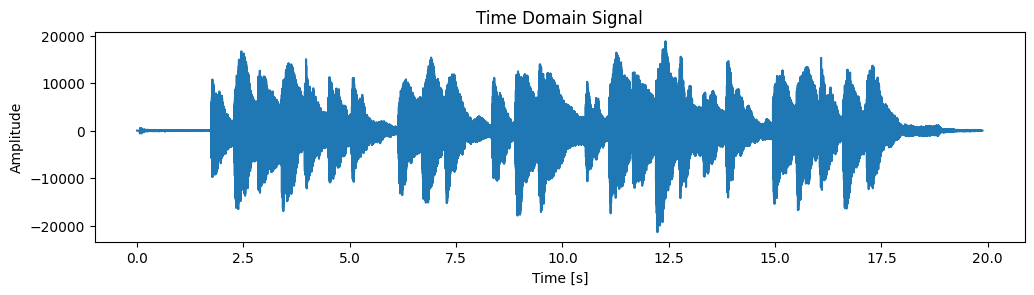

In [9]:
bandpass_signal = bandpass_filter(audio_array, 50, 3000, RATE)
plot_signal(bandpass_signal)

In [10]:
def plot_fft(signal):
    
    # Compute the Fourier Transform for the frequency-domain plot
    fft_data = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(signal), d=1/RATE)
    
    # Use only the positive half of the spectrum
    positive_freqs = fft_freq[:len(fft_freq)//2]
    fft_magnitude = np.abs(fft_data[:len(fft_data)//2])
    
    # Plot the frequency-domain signal
    plt.subplot(2, 1, 2)
    plt.plot(positive_freqs, fft_magnitude)
    plt.title('Frequency Domain Signal')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    
    plt.tight_layout()
    plt.show()

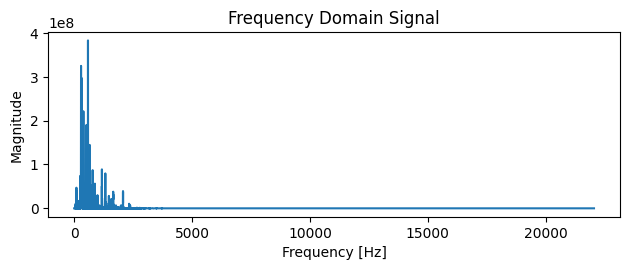

In [11]:
plot_fft(bandpass_signal)

# Splitting signal into overlapping chunks

In [12]:
import librosa
def tempo_and_duration(signal, sr):
    tempo, _ = librosa.beat.beat_track(y=signal, sr=sr)
    beat_duration = 60 / tempo  # Seconds per beat
    return tempo, beat_duration

def adaptive_window(signal, sr):
    
    tempo, beat_duration = tempo_and_duration(signal, sr)
    samples_per_beat = int(beat_duration * sr)

    # Set WINDOW_SIZE to be close to a beat duration but power of 2
    window_size = 2 ** int(round(np.log2(samples_per_beat)))
    
    # HOP_SIZE as a fraction of WINDOW_SIZE
    hop_size = window_size // 4

    return window_size, hop_size



In [13]:
adaptive_window_size, adaptive_hop_size = adaptive_window(bandpass_signal, RATE)


/var/folders/mp/c98gmxp57kn18q6jg6g9kd_w0000gn/T/ipykernel_40147/3953543489.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples_per_beat = int(beat_duration * sr)


In [14]:
import librosa
import numpy as np

def chord_recognition(audio, sr, window_size, hop_size):
    """
    Dummy chord recognition based on chroma features.
    
    Replace this function with your own chord detection algorithm.
    
    Parameters:
      audio: np.array, the audio signal.
      sr: int, sample rate.
      window_size: int, FFT window size.
      hop_size: int, hop size between successive frames.
      
    Returns:
      chord_labels: np.array, a sequence of chord labels (here, simply the index of the max chroma bin).
    """
    # Compute chroma features from the audio signal
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=window_size, hop_length=hop_size)
    # For each frame, pick the pitch class with the highest energy as the "chord label"
    chord_labels = np.argmax(chroma, axis=0)
    return chord_labels

def evaluate_chords(prediction, ground_truth):
    """
    Evaluate the predicted chords against the ground truth.
    
    This dummy evaluation uses simple frame-wise accuracy. In practice, you might use
    a more advanced metric (e.g. weighted accuracy, segment-based evaluation, etc.)
    
    Assumes both sequences are of the same length.
    """
    # Ensure both sequences are the same length (truncate the longer one)
    min_len = min(len(prediction), len(ground_truth))
    accuracy = np.mean(prediction[:min_len] == ground_truth[:min_len])
    return accuracy



In [15]:
WINDOW_SIZE = 44100  # Number of samples per window
HOP_SIZE = 11025  # Overlapping step size

signall, sr = librosa.load(AUDIO_FILE)

candidate_window_sizes = [2048, 4096, 8192, 16384, 32768, 44100]
candidate_hop_sizes = [512, 1024, 2048, 4096, 8192, 16384, 11025]
ground_truth = chord_recognition(signall, sr, WINDOW_SIZE, HOP_SIZE)

def segment_signal(signal, window_size, hop_size):
    return [signal[i:i + window_size] for i in range(0, len(signal) - window_size, hop_size)]

In [16]:
segmented_signal = segment_signal(bandpass_signal, WINDOW_SIZE, HOP_SIZE)

# To compute fft to each segment

In [17]:
def analyze_chord(segment):
    """
    Computes the FFT of a given segment and extracts dominant frequencies.

    Parameters:
        segment (np.array): The input signal segment.

    Returns:
        tuple (np.array, np.array): Frequencies and their magnitudes.
    """
    fft_data = np.fft.fft(segment)
    fft_freq = np.fft.fftfreq(len(segment), d=1/RATE)

    # Take only the positive half of the spectrum
    positive_freqs = fft_freq[:len(fft_freq)//2]
    fft_magnitude = np.abs(fft_data[:len(fft_data)//2])

    return positive_freqs, fft_magnitude

In [18]:
def frequency_to_midi(frequency):
    """
    Converts a frequency (Hz) to a MIDI note number.

    Parameters:
        frequency (float): The frequency to convert.

    Returns:
        int: MIDI note number.
    """
    return int(69 + 12 * np.log2(frequency / 440.0))

def get_notes_from_fft(freqs, magnitudes, threshold=0.1):
    """
    Detects musical notes from an FFT magnitude spectrum.

    Parameters:
        freqs (np.array): Array of frequencies from FFT.
        magnitudes (np.array): Corresponding magnitude values.
        threshold (float, optional): Minimum peak height as a fraction of the max magnitude (default is 0.1).

    Returns:
        list of int: List of detected MIDI note numbers.
    """
    peaks, _ = find_peaks(magnitudes, height=threshold * max(magnitudes))
    notes = [frequency_to_midi(freqs[p]) for p in peaks]
    return list(set(notes))  # Remove duplicates

# Dict with all chords pattern

In [19]:
CHORDS = {
    # Major chords (Root, Major third, Perfect fifth)
    (48, 52, 55): "C Major",
    (49, 53, 56): "C# Major / Db Major",
    (50, 54, 57): "D Major",
    (51, 55, 58): "D# Major / Eb Major",
    (52, 56, 59): "E Major",
    (53, 57, 60): "F Major",
    (54, 58, 61): "F# Major / Gb Major",
    (55, 59, 62): "G Major",
    (56, 60, 63): "G# Major / Ab Major",
    (57, 61, 64): "A Major",
    (58, 62, 65): "A# Major / Bb Major",
    (59, 63, 66): "B Major",

    # Minor chords (Root, Minor third, Perfect fifth)
    (48, 51, 55): "C Minor",
    (49, 52, 56): "C# Minor / Db Minor",
    (50, 53, 57): "D Minor",
    (51, 54, 58): "D# Minor / Eb Minor",
    (52, 55, 59): "E Minor",
    (53, 56, 60): "F Minor",
    (54, 57, 61): "F# Minor / Gb Minor",
    (55, 58, 62): "G Minor",
    (56, 59, 63): "G# Minor / Ab Minor",
    (57, 60, 64): "A Minor",
    (58, 61, 65): "A# Minor / Bb Minor",
    (59, 62, 66): "B Minor",

    # Diminished chords (Root, Minor third, Diminished fifth)
    (48, 51, 54): "C Diminished",
    (49, 52, 55): "C# Diminished / Db Diminished",
    (50, 53, 56): "D Diminished",
    (51, 54, 57): "D# Diminished / Eb Diminished",
    (52, 55, 58): "E Diminished",
    (53, 56, 59): "F Diminished",
    (54, 57, 60): "F# Diminished / Gb Diminished",
    (55, 58, 61): "G Diminished",
    (56, 59, 62): "G# Diminished / Ab Diminished",
    (57, 60, 63): "A Diminished",
    (58, 61, 64): "A# Diminished / Bb Diminished",
    (59, 62, 65): "B Diminished",

    # Augmented chords (Root, Major third, Augmented fifth)
    (48, 52, 56): "C Augmented",
    (49, 53, 57): "C# Augmented / Db Augmented",
    (50, 54, 58): "D Augmented",
    (51, 55, 59): "D# Augmented / Eb Augmented",
    (52, 56, 60): "E Augmented",
    (53, 57, 61): "F Augmented",
    (54, 58, 62): "F# Augmented / Gb Augmented",
    (55, 59, 63): "G Augmented",
    (56, 60, 64): "G# Augmented / Ab Augmented",
    (57, 61, 65): "A Augmented",
    (58, 62, 66): "A# Augmented / Bb Augmented",
    (59, 63, 67): "B Augmented",

    # Major 7th chords (Root, Major third, Perfect fifth, Major seventh)
    (48, 52, 55, 59): "C Major 7",
    (50, 54, 57, 61): "D Major 7",
    (52, 56, 59, 63): "E Major 7",
    (53, 57, 60, 64): "F Major 7",
    (55, 59, 62, 66): "G Major 7",
    (57, 61, 64, 68): "A Major 7",
    (59, 63, 66, 70): "B Major 7",

    # Minor 7th chords (Root, Minor third, Perfect fifth, Minor seventh)
    (48, 51, 55, 58): "C Minor 7",
    (50, 53, 57, 60): "D Minor 7",
    (52, 55, 59, 62): "E Minor 7",
    (53, 56, 60, 63): "F Minor 7",
    (55, 58, 62, 65): "G Minor 7",
    (57, 60, 64, 67): "A Minor 7",
    (59, 62, 66, 69): "B Minor 7",

    # Dominant 7th chords (Root, Major third, Perfect fifth, Minor seventh)
    (48, 52, 55, 58): "C Dominant 7",
    (50, 54, 57, 60): "D Dominant 7",
    (52, 56, 59, 62): "E Dominant 7",
    (53, 57, 60, 63): "F Dominant 7",
    (55, 59, 62, 65): "G Dominant 7",
    (57, 61, 64, 67): "A Dominant 7",
    (59, 63, 66, 69): "B Dominant 7",
}

# From notes to chord

In [20]:

def recognize_chord(notes):
    """ Match detected notes to known chords """
    for chord_notes, chord_name in CHORDS.items():
        if all(n in notes for n in chord_notes):
            return chord_name
    return "Unknown Chord"

def grid_search_parameters(audio, sr, ground_truth, window_sizes, hop_sizes):
    """
    Perform a grid search over specified window and hop sizes.
    
    Parameters:
      audio: np.array, the audio signal.
      sr: int, sample rate.
      ground_truth: np.array, ground truth chord labels.
      window_sizes: list of int, candidate FFT window sizes.
      hop_sizes: list of int, candidate hop sizes.
      
    Returns:
      best_params: tuple (window_size, hop_size) with the best performance.
      best_score: float, the best evaluation score.
    """
    best_score = -np.inf
    best_params = None

    for window_size in window_sizes:
        for hop_size in hop_sizes:
            prediction = recognize_chord(audio, sr, window_size, hop_size)
            score = evaluate_chords(prediction, ground_truth)
            if score > best_score:
                best_score = score
                best_params = (window_size, hop_size)

    return best_params, best_score


In [21]:
for segment in segmented_signal:
    freqs, mags = analyze_chord(segment)
    notes = get_notes_from_fft(freqs, mags, threshold=0.1)
    chord = recognize_chord(notes)
    print(chord)

C Major
C Major
C# Major / Db Major
C Major
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unkn

## a lot of unknown chords, try detecting silent chunks

In [22]:
def analyze_chord_silence_detection(segment):
    """
    Computes the FFT of a given segment and extracts dominant frequencies.

    Parameters:
        segment (np.array): The input signal segment.

    Returns:
        tuple (np.array, np.array): Frequencies and their magnitudes.
    """
    if np.max(np.abs(segment)) < 500:  # Adjust the silence threshold
        return None, None  # Skip processing if the segment is too silent

    fft_data = np.fft.fft(segment)
    fft_freq = np.fft.fftfreq(len(segment), d=1/RATE)

    # Take only the positive half of the spectrum
    positive_freqs = fft_freq[:len(fft_freq)//2]
    fft_magnitude = np.abs(fft_data[:len(fft_data)//2])

    return positive_freqs, fft_magnitude

# Base chord recognition

In [23]:
chords = []
for segment in segmented_signal:
    freqs, mags = analyze_chord(segment)
    
    if freqs is None or mags is None:
        print("Silent segment detected, skipping...")
        continue  # Skip silent segments

    notes = get_notes_from_fft(freqs, mags, threshold=0.05)  # Lower threshold
    chord = recognize_chord(notes)
    print(chord)
    chords.append(chord)

C Major
C Major
C Major
C Major
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
A Major
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown Chord
Unknown 

# Reconition with timestamps

In [42]:
def tempo_and_duration(signal, sr):
    tempo, beats = librosa.beat.beat_track(y=signal, sr=sr)
    beat_times = librosa.frames_to_time(beats, sr=sr)
    beat_duration = 60 / tempo  # Average beat duration in seconds
    return tempo, beat_times, beat_duration

In [43]:

def recognize_chord_routine(bandpass_signal, window_size, hop_size):
    _, beat_times, _ = tempo_and_duration(bandpass_signal, RATE)
    segmented_signal = segment_signal(bandpass_signal, window_size, hop_size)
    
    # Store detected chords with timestamps
    chords = []
    chord_timestamps = []

    for i, segment in enumerate(segmented_signal):
        freqs, mags = analyze_chord(segment)
        
        if freqs is None or mags is None:
            print(f"Silent segment at {i}, skipping...")
            continue  # Skip silent segments

        notes = get_notes_from_fft(freqs, mags, threshold=0.05)  # Lower threshold for better detection
        chord = recognize_chord(notes)
        
        start_time = beat_times[i] if i < len(beat_times) else i * adaptive_hop_size / RATE
        end_time = beat_times[i + 1] if i + 1 < len(beat_times) else start_time + (adaptive_hop_size / RATE)

        
        
        chords.append(chord)
        chord_timestamps.append([chord, start_time, end_time])
    return chord_timestamps


In [58]:
def compress_unnknown_chords(chords_timestamp):
    """
    Compresses consecutive unknown chords into a single unknown chord.
    """
    result = []
    UNKNOWN_CHORD = "Unknown Chord"
    idx = 0
    while idx < len(chords_timestamp) :
        
        chord = chords_timestamp[idx]

        new_chord = [chord[0], chord[1], chord[2]]
        
        if chord[0] == UNKNOWN_CHORD:
            new_end = chord[2]
       
            while idx < len(chords_timestamp):
                
                if(chords_timestamp[idx][0] != UNKNOWN_CHORD):
                    break
                new_end = chords_timestamp[idx][2]
                idx+=1
            new_chord[2] = new_end
            
        else:
            idx+=1
        
        
        result.append(new_chord)
   
       
    
    return result
            

                

In [48]:
def recognize_and_compress_chords(bandpass_signal, adaptive_window_size, adaptive_hop_size):
    return compress_unnknown_chords( recognize_chord_routine(bandpass_signal, adaptive_window_size, adaptive_hop_size))

## Example with ```adaptive_window_size, adaptive_hop_size``` as window size and hop

In [59]:
import librosa

# Compute tempo and beat duration


# Compute adaptive window size based on beat duration
def adaptive_window(signal, sr):
    _, beat_times, beat_duration = tempo_and_duration(signal, sr)
    samples_per_beat = int(beat_duration * sr)

    # Set WINDOW_SIZE to be close to a beat duration but power of 2
    window_size = 2 ** int(round(np.log2(samples_per_beat)))
    
    # HOP_SIZE as a fraction of WINDOW_SIZE
    hop_size = window_size // 4

    return window_size, hop_size, beat_times
# Segment the signal using adaptive window size
adaptive_window_size, adaptive_hop_size, beat_times = adaptive_window(bandpass_signal, RATE)


result =recognize_and_compress_chords(bandpass_signal, adaptive_window_size, adaptive_hop_size)

# Display the detected chords and their durations
print("\nDetected Chord Progression:")
for chord, start, end in result:
    print(f"{chord}: {start:.2f}s → {end:.2f}s (Duration: {end - start:.2f}s)")

/var/folders/mp/c98gmxp57kn18q6jg6g9kd_w0000gn/T/ipykernel_40147/2870844017.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples_per_beat = int(beat_duration * sr)



Detected Chord Progression:
C Major: 1.76s → 2.87s (Duration: 1.10s)
C# Major / Db Major: 2.87s → 3.97s (Duration: 1.10s)
Unknown Chord: 3.97s → 10.40s (Duration: 6.43s)
B Major: 10.40s → 10.77s (Duration: 0.37s)
Unknown Chord: 10.77s → 18.58s (Duration: 7.80s)


In [ ]:
import numpy as np
import time
import sounddevice as sd
import fluidsynth

# Initialize FluidSynth
fs = fluidsynth.Synth()
fs.start(driver="coreaudio")  # Use the appropriate driver for your OS (e.g., "coreaudio" for macOS)
sfid = fs.sfload("utils/piano/SalC5Light2.sf2")  # Load a SoundFont file (replace with a valid .sf2 file)
fs.program_select(0, sfid, 0, 0)  # Select instrument (0 = default piano)

def transform_chords_dict(chords_dict):
    """
    Transforms the given CHORDS dictionary into a CHORD_NOTES dictionary 
    where the chord names are keys and the corresponding MIDI note tuples are values.
    """
    return {name: notes for notes, name in chords_dict.items()}


# Transform dictionary
CHORD_NOTES = transform_chords_dict(CHORDS)

# Play detected chords
for chord, start, end in chord_timestamps:
    if chord in CHORD_NOTES:
        notes = CHORD_NOTES[chord]
        print(f"Playing: {chord}")

        # Play notes
        for note in notes:
            fs.noteon(0, note, 100)  # Channel 0, Note number, Velocity

        time.sleep(end-start)  # Hold the chord for 1 second

        # Stop notes
        for note in notes:
            fs.noteoff(0, note)

        time.sleep(0.2)  # Short pause between chords

# Shutdown FluidSynth
fs.delete()

Playing: C Major
Playing: C# Major / Db Major
Playing: B Major


# Plotting

In [ ]:
def plot_timeline(recognizions):
    #TODO
    return 

In [ ]:
inputs = [
    [],
    []
]

recognizions = [recognize_and_compress_chords(bandpass_signal, w,h) for w,h in inputs]
plot_timeline(recognizions)

